# Классификация нефти и газа

## Описание исследования

Нефтегазовая отрасль промышленности имеет несколько важных особенностей, которые обуславливают необходимость поиска инновационных решений – это непрерывность и высокая сложность технологической цепи, которая начинается с геологической разведки, а заканчивается доставкой нефти и газа потребителям.

Сектор разведки и добычи включает в себя поиск рентабельных залежей нефти и газа на берегу и в море, бурение поисковоразведочных скважин и эксплуатацию скважин, дающих нефть, газ и жидкие продукты залежей или их смесь.

Алгоритмы машинного обучения могут быть полезны для решения различных задач в нефтегазовой отрасли, в частности для построения прогнозов разработки новых рентабельных месторождений.

Вам предлагается реализовать алгоритм машинного обучения, который позволит по различным параметрам определить место залежей нефти и газа: на суше, на море.

*Примечание: Задача предоставлена в рамках программы классического ML SkillFactory x НИЯУ МИФИ, программы "Машинное обучение с учителем" Яндекс х НИЯУ МИФИ, а также программы "Прикладного анализа данных" Цифровой кафедры НИЯУ МИФИ.*

*Данные были собраны как из открытых источников, так и сгенерированы самостоятельно.*

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Image

## Исследование и анализ датасета

### Загрузка данных:

In [2]:
train = pd.read_csv('train_oil.csv')
test = pd.read_csv('oil_test.csv')

In [3]:
print(f"Train: {train.shape}, Test: {test.shape}")

Train: (309, 20), Test: (133, 19)


In [4]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Field name                      309 non-null    object 
 1   Reservoir unit                  309 non-null    object 
 2   Country                         282 non-null    object 
 3   Region                          271 non-null    object 
 4   Basin name                      271 non-null    object 
 5   Tectonic regime                 309 non-null    object 
 6   Latitude                        282 non-null    float64
 7   Longitude                       279 non-null    float64
 8   Operator company                309 non-null    object 
 9   Onshore/Offshore                309 non-null    object 
 10  Hydrocarbon type                309 non-null    object 
 11  Reservoir status                309 non-null    object 
 12  Structural setting              309 

None

### Проверка целевой переменной `Onshore/Offshore`

In [5]:
print("\nРаспределение целевой переменной (Onshore/Offshore):")
display(train['Onshore/Offshore'].value_counts(normalize=True))


Распределение целевой переменной (Onshore/Offshore):


Onshore/Offshore
ONSHORE             0.705502
OFFSHORE            0.278317
ONSHORE-OFFSHORE    0.016181
Name: proportion, dtype: float64

In [6]:
mixed_count = (train['Onshore/Offshore'] == 'ONSHORE-OFFSHORE').sum()
print(f"Смешанных случаев: {mixed_count} ({mixed_count/len(train)*100:.1f}%)")

Смешанных случаев: 5 (1.6%)


### Подготовка X и y

Т.к. по заданию нужно определять `Onshore/Offshore`, а значение `ONSHORE-OFFSHORE` встречается 5 раз (1.6%), то мы удалим эти строки:

In [7]:
train = train[train['Onshore/Offshore'] != 'ONSHORE-OFFSHORE'].copy()

Целевая переменная:

In [8]:
y_train = train['Onshore/Offshore'].map({'OFFSHORE': 0, 'ONSHORE': 1})

Признаки (удаляем целевую переменную из train, в test её и так нет):

In [9]:
X_train = train.drop('Onshore/Offshore', axis=1)
X_test = test.copy()

In [10]:
print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")


X_train: (304, 19), y_train: (304,)
X_test: (133, 19)


### Базовый анализ признаков

#### Проверка пропусков

In [11]:
print("Пропуски в train:")
display(X_train.isnull().sum().sort_values(ascending=False).head(10))

print("\nПропуски в test:")
display(X_test.isnull().sum().sort_values(ascending=False).head(10))

Пропуски в train:


Region                            37
Basin name                        37
Longitude                         29
Country                           26
Latitude                          26
Field name                         0
Depth                              0
Porosity                           0
Thickness (net pay average ft)     0
Thickness (gross average ft)       0
dtype: int64


Пропуски в test:


Region                            16
Longitude                         16
Country                           13
Latitude                          13
Basin name                         8
Field name                         0
Depth                              0
Porosity                           0
Thickness (net pay average ft)     0
Thickness (gross average ft)       0
dtype: int64

#### Типы данных

In [12]:
display(X_train.dtypes.value_counts())

object     12
float64     6
int64       1
Name: count, dtype: int64

## Feature Engineering

Для улучшения качества предсказаний и предоставления модели дополнительной информации о геологических характеристиках месторождений **создадим несколько новых инженерных признаков**. Эти признаки основаны на комбинации существующих переменных и извлечении семантической информации из текстовых полей.

In [13]:
def add_simple_features(df):
    df = df.copy()
    
    # Отношение толщин
    df['net_to_gross'] = df['Thickness (net pay average ft)'] / df['Thickness (gross average ft)'].replace(0, 1)
    
    # Производительность пласта
    df['flow_capacity'] = df['Porosity'] * df['Permeability']
    
    # Признак: содержит ли бассейн "SEA", "GULF", "OCEAN"
    df['contains_sea'] = df['Basin name'].str.contains('SEA|GULF|OCEAN', case=False, na=False).astype(int)
    
    # Количество тектонических режимов
    df['tectonic_count'] = df['Tectonic regime'].apply(lambda x: len(str(x).split('/')) if pd.notnull(x) else 0)
    
    return df

## Предобработка данных

#### Удаление избыточных для задачи признаки

In [14]:
to_drop = ['Field name', 'Operator company', 'Reservoir unit']

X_train = X_train.drop(columns=to_drop, errors='ignore')
X_test = X_test.drop(columns=to_drop, errors='ignore')

### Добавление новых признаков

In [15]:
X_train = add_simple_features(X_train)
X_test = add_simple_features(X_test)

### Разделение признаков на типы

Числовые признаки:

In [16]:
numeric_features = ['Depth', 'Porosity', 'Permeability', 
                   'Thickness (gross average ft)', 
                   'Thickness (net pay average ft)',
                   'Latitude', 'Longitude',
                   'net_to_gross', 'flow_capacity', 'tectonic_count']

Категориальные признаки с пропусками (заполним модой):

In [17]:
categorical_features_with_na = ['Country', 'Region', 'Basin name']

Категориальные признаки без пропусков (в основном):

In [18]:
categorical_features_no_na = ['Tectonic regime', 'Hydrocarbon type', 
                             'Reservoir status', 'Structural setting',
                             'Reservoir period', 'Lithology', 'contains_sea']

### Создадание трансформеров

Для числовых признаков заполним медианой и масштабируем:

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Для категориальных с пропусками заполним модой и one-hot:

In [20]:
categorical_transformer_with_na = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

Для категориальных без пропусков только one-hot:

In [21]:
categorical_transformer_no_na = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Объединение в ColumnTransformer

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_with_na', categorical_transformer_with_na, categorical_features_with_na),
        ('cat_no_na', categorical_transformer_no_na, categorical_features_no_na)
    ])

### Применение к train

Обучим на train, трансформируем оба набора:

In [23]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

После обработки:

In [24]:
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")

X_train_processed: (304, 301)
X_test_processed: (133, 301)


Пропуски в обработанных данных:

In [25]:
print(f"Train: {np.isnan(X_train_processed).sum()}")
print(f"Test: {np.isnan(X_test_processed).sum()}")

Train: 0
Test: 0


### Особенности обработки

1. **Field name (название месторождения):** это уникальный идентификатор, но может помочь модели. Оставим как категориальный признак.
2. **Географические координаты:** обрабатываем как числовые признаки.
3. **Tectonic regime:** часто содержит несколько значений через `/`. Можно потом создать дополнительный признак "количество тектонических режимов".
4. **OneHotEncoder** с `handle_unknown='ignore'`: важно для тестовых данных, где могут быть новые категории.

Простые преобразования:

## Подбор признаков, их анализ и оценка важности

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Получаем имена признаков после OneHotEncoding:

In [27]:
cat_with_na_features = preprocessor.named_transformers_['cat_with_na'].named_steps['onehot'].get_feature_names_out(categorical_features_with_na)
cat_no_na_features = preprocessor.named_transformers_['cat_no_na'].named_steps['onehot'].get_feature_names_out(categorical_features_no_na)
all_features = list(numeric_features) + list(cat_with_na_features) + list(cat_no_na_features)

Важность признаков:

In [28]:
feature_importances = pd.DataFrame({
    'feature': all_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-20 важных признаков:")
display(feature_importances.head(20))

Топ-20 важных признаков:


,feature,importance
5,Latitude,0.058496
6,Longitude,0.057792
7,net_to_gross,0.051792
53,Region_EUROPE,0.047273
4,Thickness (net pay average ft),0.044582
9,tectonic_count,0.038904
0,Depth,0.033801
300,contains_sea_1,0.031637
2,Permeability,0.027922
8,flow_capacity,0.027715


### Визуализация

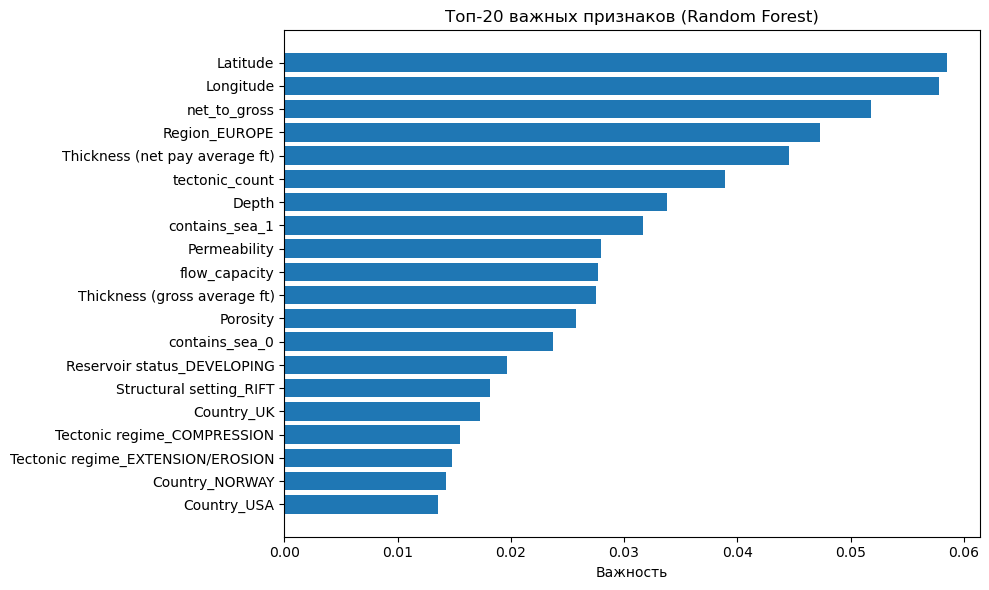

In [29]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'].head(20)[::-1], 
         feature_importances['importance'].head(20)[::-1])
plt.xlabel('Важность')
plt.title('Топ-20 важных признаков (Random Forest)')
plt.tight_layout()
plt.show()

### Анализ: типы важных признаков

In [30]:
top_features = feature_importances.head(30)
top_features = top_features.copy()
print("\nРаспределение типов в топ-30 признаков:\n")

def get_feature_type(feature_name):
    if feature_name in numeric_features:
        return 'numeric'
    for cat_feat in categorical_features_with_na + categorical_features_no_na:
        if feature_name.startswith(cat_feat):
            return f'categorical: {cat_feat}'
    return 'other'

top_features['type'] = top_features['feature'].apply(get_feature_type)
display(top_features['type'].value_counts())


Распределение типов в топ-30 признаков:



type
numeric                            10
categorical: Country                4
categorical: Tectonic regime        4
categorical: Region                 3
categorical: contains_sea           2
categorical: Reservoir status       2
categorical: Structural setting     2
categorical: Basin name             2
categorical: Reservoir period       1
Name: count, dtype: int64

## Обучение нескольких моделей, их сравнение

In [31]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

In [32]:
results = []
for name, model in models.items():
    cv_f1 = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='f1')
    cv_acc = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')
    
    model.fit(X_train_processed, y_train)
    train_acc = model.score(X_train_processed, y_train)
    
    results.append({
        'Model': name,
        'CV F1 Mean': cv_f1.mean(),
        'CV F1 Std': cv_f1.std(),
        'CV Accuracy Mean': cv_acc.mean(),
        'Train Accuracy': train_acc
    })

results_df = pd.DataFrame(results)

print("Сравнение моделей:\n")
print(results_df.sort_values('CV F1 Mean', ascending=False).to_string(index=False))

Сравнение моделей:

              Model  CV F1 Mean  CV F1 Std  CV Accuracy Mean  Train Accuracy
  Gradient Boosting    0.927582   0.025159          0.891530        1.000000
      Random Forest    0.920449   0.028627          0.878251        1.000000
                SVM    0.907372   0.023908          0.865301        0.993421
Logistic Regression    0.897905   0.026271          0.852186        0.970395


### Визуализация сравнения

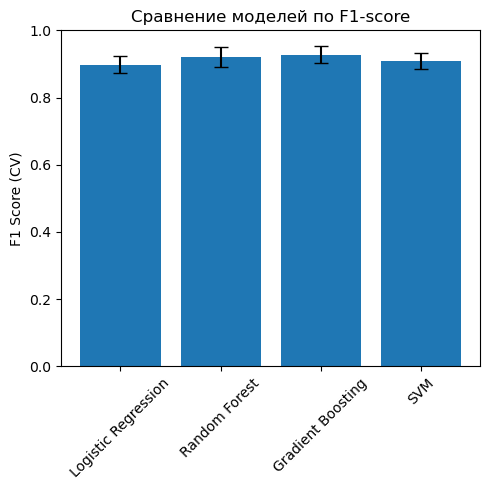

In [33]:
plt.figure(figsize=(5, 5))
x = range(len(results_df))
plt.bar(x, results_df['CV F1 Mean'], yerr=results_df['CV F1 Std'], capsize=5)
plt.xticks(x, results_df['Model'], rotation=45)
plt.ylabel('F1 Score (CV)')
plt.title('Сравнение моделей по F1-score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Подбор гиперпараметров

Упрощенная сетка для быстрого подбора:

In [34]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

In [35]:
gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 4, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [36]:
print("Лучшие параметры:", grid_search.best_params_)
print(f"Лучший F1-score: {grid_search.best_score_:.3f}")

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Лучший F1-score: 0.943


## Выбор лучшей модели и объяснение

In [37]:
best_model = grid_search.best_estimator_
final_scores = cross_val_score(best_model, X_train_processed, y_train, cv=5, scoring='f1')

**Выбор модели:** GradientBoostingClassifier

**Причины:**
1. **Наивысший F1-score**: 0.943 после оптимизации (было 0.928)
2. **Лучшая обобщающая способность**: CV F1-score (0.928) выше, чем у других моделей
3. **Баланс точности**: Train accuracy = 1.000, но CV accuracy = 0.892 показывает приемлемый уровень обобщения
4. **Оптимальные параметры**: `learning_rate=0.2`, `max_depth=3`, `n_estimators=100`, `min_samples_split=10`

**Оптимизация дала улучшение +1.5% F1-score.**

## Предсказание на тестовых данных

In [38]:
best_model.fit(X_train_processed, y_train)
y_test_pred = best_model.predict(X_test_processed)

submission = pd.DataFrame({
    'index': range(len(y_test_pred)),
    'Onshore/Offshore': y_test_pred
})

In [39]:
print(f"Распределение предсказаний:\n")
display(submission['Onshore/Offshore'].value_counts())

Распределение предсказаний:



Onshore/Offshore
1    98
0    35
Name: count, dtype: int64

Сохранение в требуемом формате:

In [40]:
submission.to_csv('submission.csv', index=False)

## Скриншот с лидерборда Kaggle

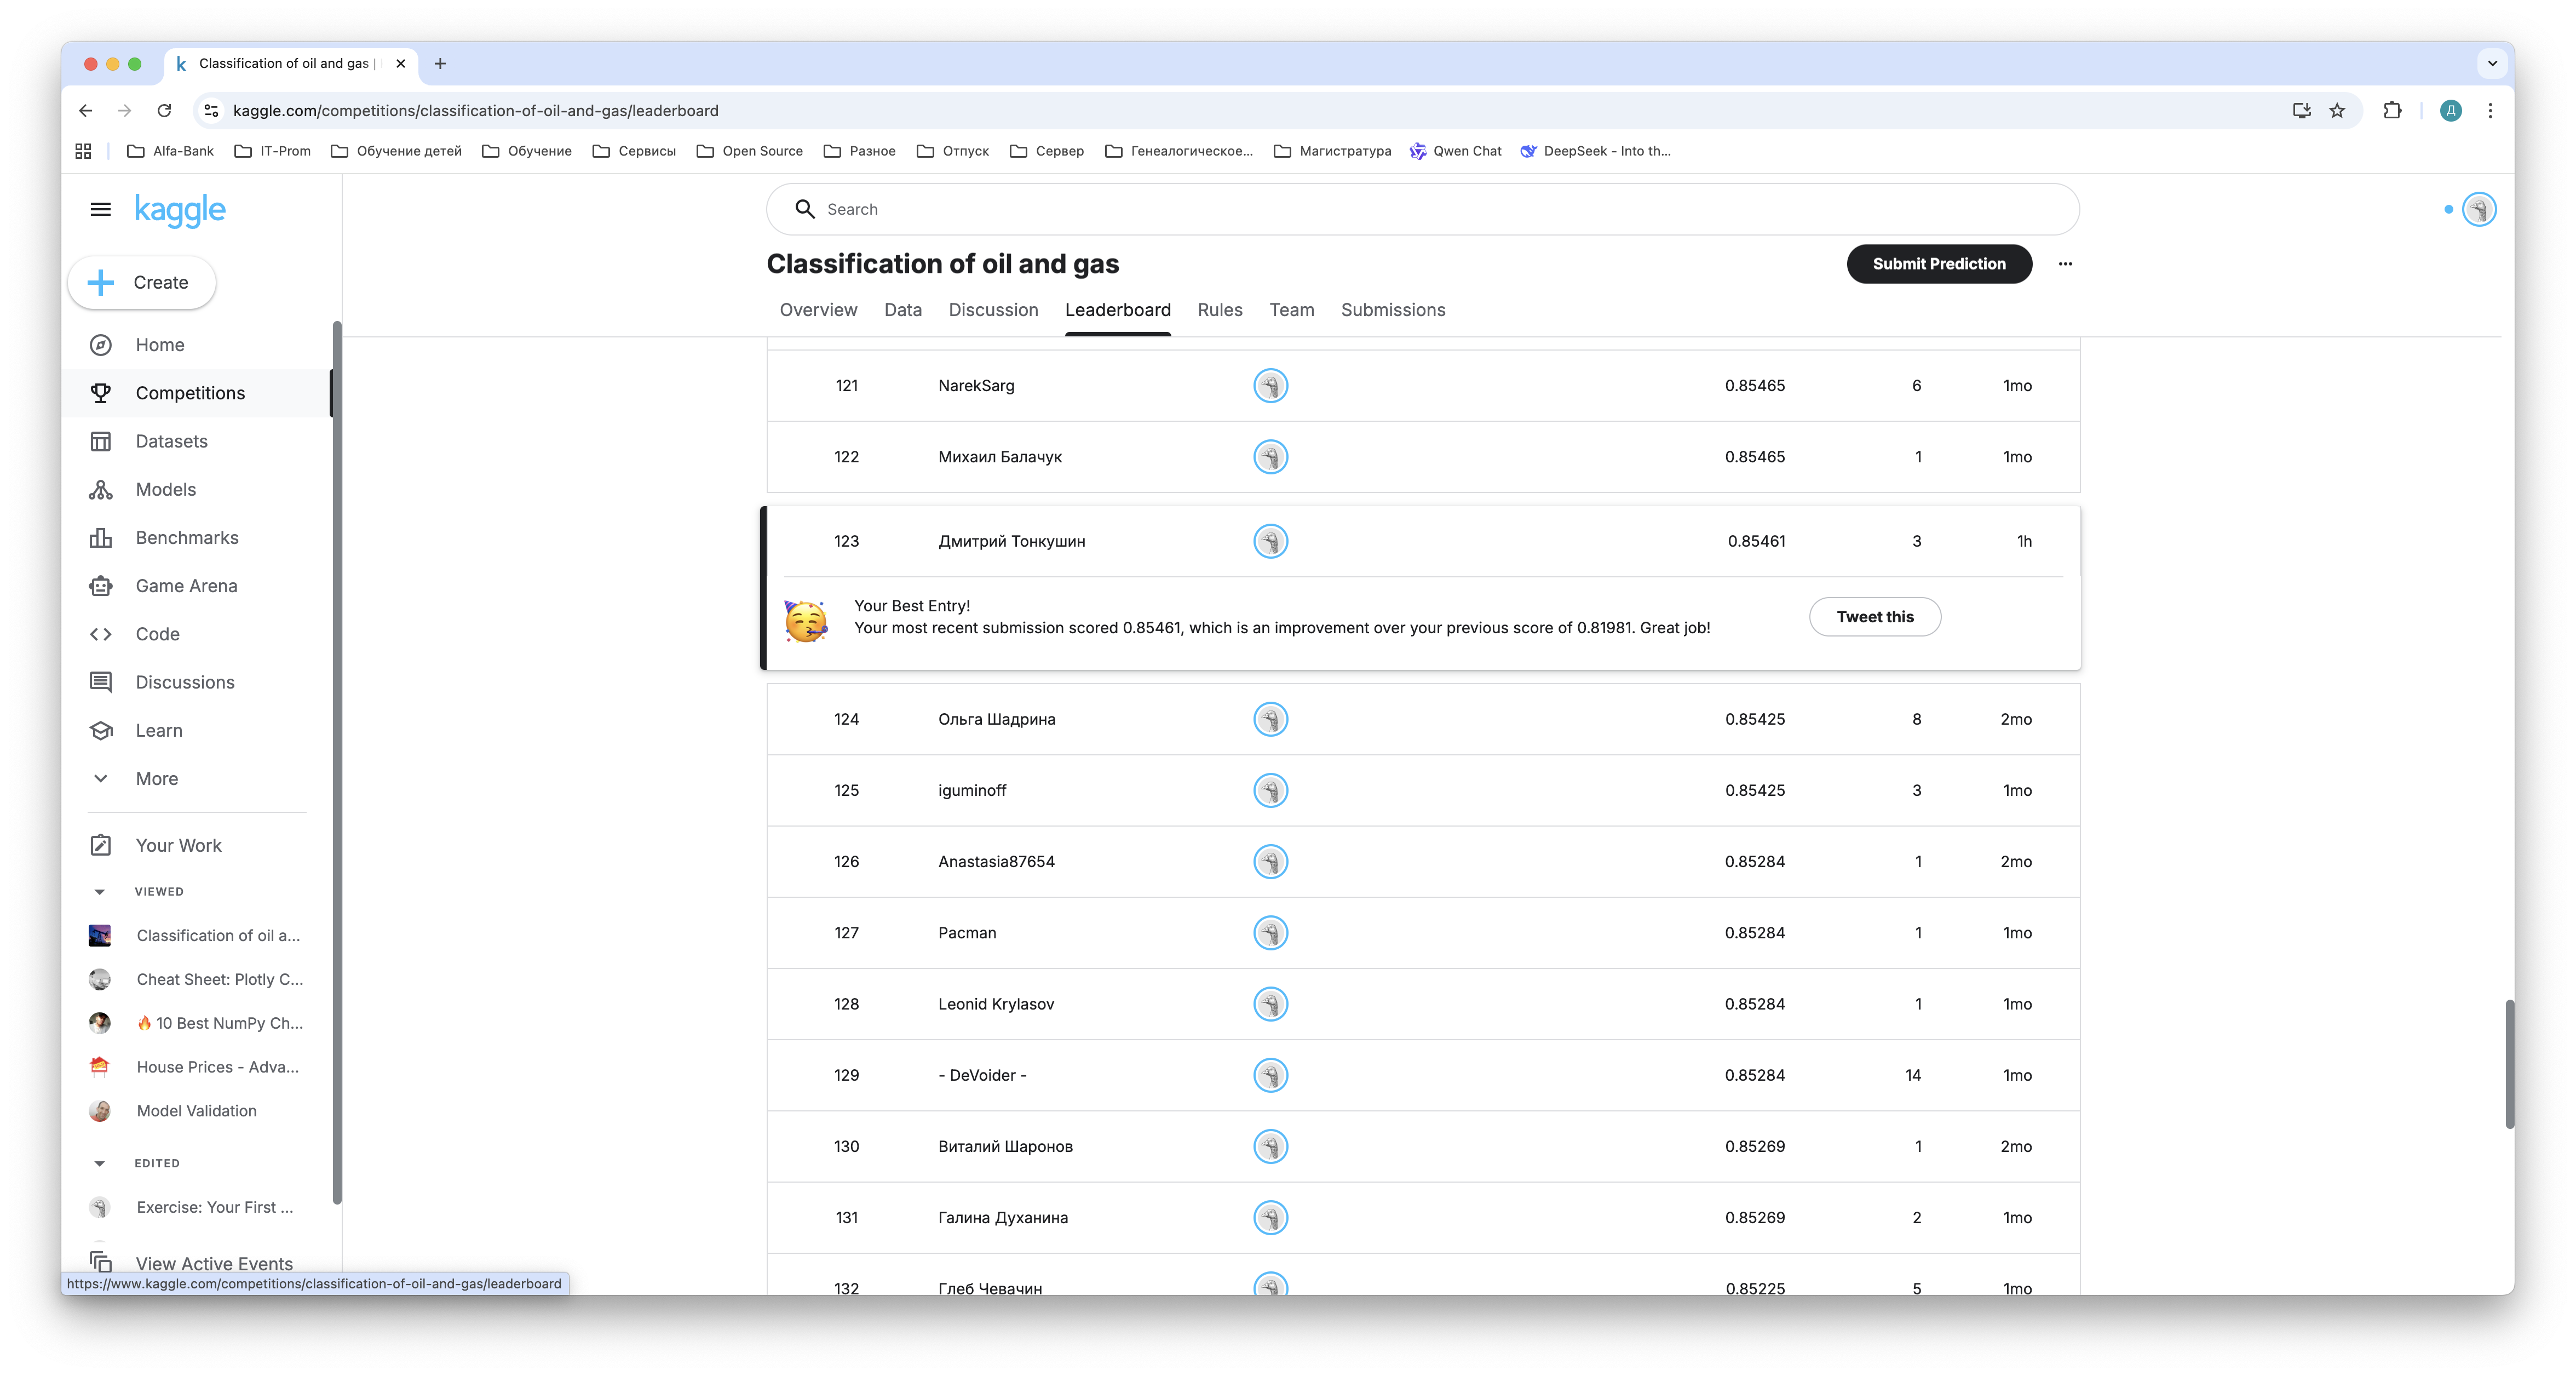

In [41]:
Image(filename='kaggle_leaderboard.png')